# 前置作業

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
# from torch.utils import data
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [ ]:
data = pd.read_csv('combined_data.csv')

# 數據準備


In [ ]:
# 分割訓練集和測試集
# 根據Material和Condition進行數據劃分
# train_data = data[~((data['Material'] == 13) & (data['Condition'] == 'd'))]
train_data = data[~((data['Material'] == 13))]
test_data = data[(data['Material'] == 13) & (data['Condition'] == 'c')]

# 選擇 validation set & 訓練集排除這部分數據
validation_data = data[(data['Material'] == 13) & (data['Condition'] == 'b')]
# train_data = train_data[~((train_data['Material'] == 5) & (train_data['Condition'] == 'b'))]
# 檢查劃分結果
print(f"訓練集樣本數: {train_data.shape[0]}")
print(f"驗證集樣本數: {validation_data.shape[0]}")
print(f"測試集樣本數: {test_data.shape[0]}")

訓練集樣本數: 192000
驗證集樣本數: 4000
測試集樣本數: 4000


In [ ]:
# 需要標準化的特徵列
feature_columns = [f'y{i:02}' for i in range(1, 11)]

# 使用訓練集來fit標準化
scaler = MinMaxScaler()

# 對訓練集標準化
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])

# 對驗證集使用相同的縮放進行標準化
validation_data[feature_columns] = scaler.transform(validation_data[feature_columns])

# 對測試集使用相同的縮放進行標準化
test_data[feature_columns] = scaler.transform(test_data[feature_columns])

<ipython-input-4-942d77fab10d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
<ipython-input-4-942d77fab10d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data[feature_columns] = scaler.transform(validation_data[feature_columns])
<ipython-input-4-942d77fab10d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
import numpy as np

def create_sequences(data, feature_columns, window_size_in=50, window_size_out=25):
    sequences = []
    targets = []

    materials = data['Material'].unique()
    conditions = data['Condition'].unique()

    for material in materials:
        for condition in conditions:
            material_condition_data = data[(data['Material'] == material) & (data['Condition'] == condition)]

            # 獲取特徵數據
            features = material_condition_data[feature_columns].values

            # 切割序列
            for i in range(len(features) - window_size_in - window_size_out + 1):
                seq_in = features[i:i+window_size_in]
                seq_out = features[i+window_size_in:i+window_size_in+window_size_out]
                sequences.append(seq_in)
                targets.append(seq_out)

    return np.array(sequences), np.array(targets)

# 創建訓練集的 sequence windows
X_train, y_train = create_sequences(train_data, feature_columns)

# 創建測試集的 sequence windows
X_test, y_test = create_sequences(test_data, feature_columns)

# 創建 validation set 的 sequence windows
X_val, y_val = create_sequences(validation_data, feature_columns)

print(f"訓練集序列數: {X_train.shape[0]}")
print(f"測試集序列數: {X_val.shape[0]}")
print(f"測試集序列數: {X_test.shape[0]}")

訓練集序列數: 188448
測試集序列數: 3926
測試集序列數: 3926


In [ ]:
# 將數據轉換為 Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# 創建 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 創建 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 檢查 Dataloader
print(f"訓練集批次數: {len(train_loader)}")
print(f"測試集批次數: {len(test_loader)}")
print(f"驗證集批次數: {len(val_loader)}")

訓練集批次數: 2945
測試集批次數: 62
驗證集批次數: 62


# Model-LSTM Seq2Seq


In [ ]:
# 設置參數
input_timesteps = 50  # 輸入的時間步
output_timesteps = 25  # 預測的時間步
features = 10  # 每個時間步的特徵數量
latent_dim = 100  # LSTM 層的單元數

# 編碼器
encoder_inputs = Input(shape=(input_timesteps, features))

# 第一層 LSTM，return_sequences=True 以返回整個輸出序列
encoder_lstm_1 = LSTM(latent_dim, return_sequences=True)(encoder_inputs)

# 第二層 LSTM，return_sequences=False 只返回最後的狀態
encoder_lstm_2 = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm_2(encoder_lstm_1)

# 使用隱藏狀態來初始化解碼器
encoder_states = [state_h, state_c]

# 解碼器
decoder_inputs = RepeatVector(output_timesteps)(state_h)  # 重複隱藏狀態 25 次
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# TimeDistributed 將 Dense 應用於每個時間步
decoder_dense = TimeDistributed(Dense(features))
decoder_outputs = decoder_dense(decoder_outputs)

# 建立模型
model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

# 檢查模型結構
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 50, 100)        │         44,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 100), (None,   │         80,400 │ lstm[0][0]             │
│                           │ 100), (None, 100)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 25, 100)        │              0 │ lstm_1[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 25, 100)        │         80,400 │ repeat_vector[0][0],   │
│                           │                        │                │ lstm_1[0][1],          │
│                           │                        │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 25, 10)         │          1,010 │ lstm_2[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 206,210 (805.51 KB)

 Trainable params: 206,210 (805.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

# 設定 EarlyStopping 回調
early_stopping = EarlyStopping(
    monitor='val_loss',  # 根據驗證損失來判斷
    patience=10,  # 連續10個epoch沒有改善則停止
    restore_best_weights=True  # 停止訓練後恢復到最好的權重
)

In [ ]:
# 訓練參數
batch_size = 64  # 每個批次處理64個樣本
epochs = 100  # 訓練週期

# 模型訓練
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1, # 顯示訓練進度
    callbacks=[early_stopping]
)

Epoch 1/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 381s 127ms/step - loss: 2.6650e-04 - val_loss: 3.6676e-06
Epoch 2/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 372s 124ms/step - loss: 7.2249e-06 - val_loss: 7.9865e-07
Epoch 3/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 362s 123ms/step - loss: 4.5154e-06 - val_loss: 9.9249e-07
Epoch 4/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 385s 124ms/step - loss: 4.4424e-06 - val_loss: 6.0059e-07
Epoch 5/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 379s 123ms/step - loss: 2.3268e-06 - val_loss: 9.8677e-07
Epoch 6/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 382s 123ms/step - loss: 2.0929e-06 - val_loss: 1.2352e-06
Epoch 7/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 363s 123ms/step - loss: 2.1687e-06 - val_loss: 3.8503e-07
Epoch 8/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 363s 123ms/step - loss: 1.2234e-06 - val_loss: 2.9759e-07
Epoch 9/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 386s 125ms/step - loss: 1.6220e-06 - val_loss: 6.5815e-07
Epoch 10/100
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 377s 123ms/step - loss: 1.2707e-06 - val_loss: 

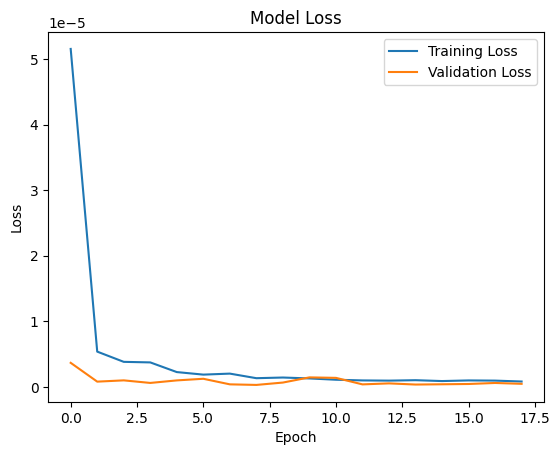

In [ ]:
# 繪製訓練損失和驗證損失
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 後處理

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
# 將模型保存為一個 .h5 文件
model.save('my_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('LSTM_Seq2Seq第三版.keras')

In [ ]:
model = load_model('LSTM_Seq2Seq第三版.keras')

In [ ]:
# 開始逐步預測
def stepwise_prediction(model, initial_sequence, prediction_steps=3950, step_size=25):
    predictions = []
    current_input = initial_sequence.reshape(1, 50, 10)  # 保證輸入格式正確

    for _ in range(0, prediction_steps, step_size):
        # 使用模型進行預測
        predicted = model.predict(current_input)
        predictions.append(predicted)

        # 更新輸入，使用最後25筆預測結果加入序列
        current_input = np.concatenate((current_input[:, -25:, :], predicted), axis=1)

    # 將所有預測結果合併為一個大的序列
    return np.concatenate(predictions, axis=1)

# 使用模型進行逐步預測，假設 initial_sequence 是前 50 筆的數據
initial_sequence = X_test[0]  # 測試集中的初始數據
predicted_sequence = stepwise_prediction(model, initial_sequence)

# 計算模型預測的 MSE
true_sequence = test_data[feature_columns].values[-3950:]  # 將真實值展開為 (3950, 10)
model_mse = mean_squared_error(true_sequence, predicted_sequence.reshape(-1, 10))

print(f"模型的 MSE: {model_mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

# 測試結果

In [ ]:
initial_sequence = X_test[0]
# 基於前 50 筆資料的平均值進行基線預測
baseline_prediction = np.mean(initial_sequence, axis=0)

# 將平均值複製來生成 3950 筆預測
baseline_sequence = np.tile(baseline_prediction, (3950, 1))

# 計算基線 MSE
baseline_mse = mean_squared_error(true_sequence, baseline_sequence)

print(f"基線 (前 50 筆均值) 的 MSE: {baseline_mse}")

基線 (前 50 筆均值) 的 MSE: 0.10496929027270967


In [ ]:
# 使用模型進行逐步預測，假設 initial_sequence 是前 50 筆的數據
initial_sequence = X_test[0]  # 測試集中的初始數據
predicted_sequence = stepwise_prediction(model, initial_sequence)

# 計算模型預測的 MSE
true_sequence = test_data[feature_columns].values[-3950:]  # 將真實值展開為 (3950, 10)
model_mse = mean_squared_error(true_sequence, predicted_sequence.reshape(-1, 10))

print(f"模型的 MSE: {model_mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [ ]:
predicted_sequence_scaled = predicted_sequence.reshape(-1, 10)
predicted_sequence_unscaled = scaler.inverse_transform(predicted_sequence_scaled)
true_sequence_unscaled = scaler.inverse_transform(true_sequence)
model_mse_original_scale = mean_squared_error(true_sequence_unscaled , predicted_sequence_unscaled)
print(f"還原後的測試集均方誤差 (MSE): {model_mse_original_scale}")

還原後的測試集均方誤差 (MSE): 4242.824577736676


In [ ]:
predicted_sequence_unscaled

array([[1025.6567  ,  635.8706  , 1544.3057  , ...,  628.78357 ,
         643.21576 ,  779.8312  ],
       [ 954.8589  ,  566.41736 , 1457.5021  , ...,  556.0328  ,
         546.92615 ,  738.74457 ],
       [ 952.7936  ,  582.3274  , 1447.1246  , ...,  595.3091  ,
         573.5616  ,  791.5039  ],
       ...,
       [ 103.662674,  100.07056 ,  104.92226 , ...,  114.93251 ,
         111.4126  ,  100.86907 ],
       [ 103.604034,  100.027565,  104.87072 , ...,  114.87404 ,
         111.35111 ,  100.82143 ],
       [ 103.544174,   99.9816  ,  104.819176, ...,  114.81507 ,
         111.289505,  100.77187 ]], dtype=float32)

In [ ]:
initial_sequence = X_test[0]
# 基於前 50 筆資料的平均值進行基線預測
baseline_prediction = np.mean(initial_sequence, axis=0)

# 將平均值複製來生成 3950 筆預測
baseline_sequence = np.tile(baseline_prediction, (3950, 1))
baseline_sequence_unscaled = scaler.inverse_transform(baseline_sequence)
# 計算基線 MSE
baseline_unscaled_mse = mean_squared_error(true_sequence_unscaled, baseline_sequence_unscaled)

print(f"還原後亂猜均方誤差 MSE: {baseline_unscaled_mse}")

還原後亂猜均方誤差 MSE: 997298.4656491021
